**Import Statements**

In [1]:
!pip install stanza
#!pip install custom_preprocessing
#!pip install googletrans

     |████████████████████████████████| 574 kB 598 kB/s 


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import fasttext
import fasttext.util
import glob
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import sklearn
import stanza
import string
import tensorflow as tf
import time
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras import layers
from keras.layers import Embedding, Flatten, Dense , Dense, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from shutil import copyfile
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import neighbors
from sklearn import tree
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, precision_score, accuracy_score, roc_curve, roc_auc_score, mean_squared_error
from sklearn.metrics import zero_one_loss, explained_variance_score, f1_score, auc, balanced_accuracy_score, precision_recall_curve
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.keras import backend as K
from textblob import TextBlob 
from tqdm import tqdm,tqdm_notebook
from transformers import *
from xgboost import XGBClassifier
sklearn.__version__
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# copyfile(src = "../input/customer-preprocessingpy/custom_preprocessing.py", dst = "./custom_preprocessing.py")
# copyfile(src = "../input/class-metricpy/class_metric.py", dst = "./class_metric.py")

# from custom_preprocessing import *
# from class_metric import *

sns.set(style="darkgrid")

tqdm().pandas()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
0it [00:00, ?it/s]


In [3]:
##Paramaters
TEXT = "text"
LABEL = "label"
language = "en"

**0 Import Data**

In [4]:
training_csv = pd.read_csv('/kaggle/input/dontpatronizemepcl/dontpatronizeme_pcl.tsv', skiprows=3, sep='\t', names=["paragraph_id", "keyword", "country_code", "text", "label"])
#training_csv.columns = ["paragraph_id", "keyword", "country_code", "paragraph", "label"]
df = training_csv.drop(["paragraph_id", "keyword"], axis = 1, inplace = False)
df["label"] = df.apply(lambda x: 1 if x["label"] > 1 else 0, axis = 1)

**1 Preprocess**

In [5]:
def remove_upper_case(text):
    sentences = text.split("\n")
    new_sentences = []
    for i in sentences:
        words = text.split()
        stripped = [w.title() if w.isupper() else w for w in words]
        new_sentences.append(" ".join(stripped))
        return "\n".join(new_sentences)
    
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_stop_words(x, stop_word):
    x_new = text_to_word_sequence(x)
    x_ = []
    for i in x_new:
        if i not in stop_word:
            x_.append(i)
        return " ".join(x_)

In [6]:
df["text"] = df["text"].astype(str).progress_apply(remove_upper_case)
df["text"] = df["text"].astype(str).progress_apply(remove_URL)
df["text"] = df["text"].astype(str).progress_apply(remove_html)
df["text"] = df["text"].astype(str).progress_apply(remove_emoji)

df["text"] = df["text"].progress_apply(lambda x: x.replace("'ve", " have"))
df["text"] = df["text"].progress_apply(lambda x: x.replace("n't", " not"))
df["text"] = df["text"].progress_apply(lambda x: x.replace("'re", " are"))

print(df.head())

100%|██████████| 10469/10469 [00:00<00:00, 476419.64it/s]

  country_code                                               text  label
1           ph  We  are living in times of absolute insanity ,...      0
2           gh  In Libya today , there are countless number of...      0
3           ie  White House press secretary Sean Spicer said t...      0
4           nz  Council customers only signs would be displaye...      0
5           ca  " Just like we received migrants fleeing El Sa...      0


**2 Exploratory Data Analysis**

In [7]:
df['char_count'] = df["text"].apply(len) # Number of characters in the string
df['word_count'] = df["text"].apply(lambda x: len(x.split())) # Number of words in the string 
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
#df['punctuation_count'] = df["text"].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
#df['upper_case_word_count'] = df["text"].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


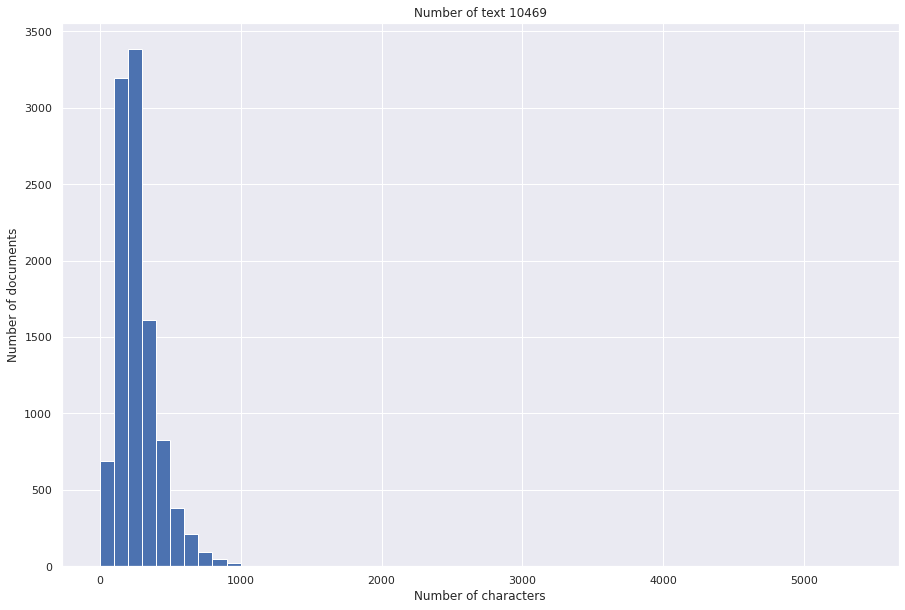

In [8]:
# ---- Show the number of characters per document
plt.figure(figsize=(15,10))
max_x = 10000 if df.char_count.max()>10000 else df.char_count.max()
plt.hist(df.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Number of text {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

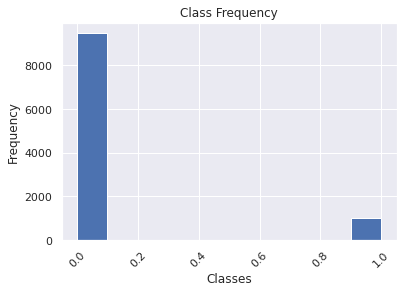

In [9]:
df["label"].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")
plt.savefig("distrib_classes.png")

In [10]:
stop_word = np.loadtxt("../input/stopwordsentxt/stopwords_en.txt", dtype=str)

**3 Top words before removing stops**

In [11]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)  
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)  
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_words_sw( corpus, stop_word=None, lang="fr", n=None):
    vec = CountVectorizer(stop_words = "english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) 
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram_sw(corpus, stop_word=None, lang="en", n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram_sw(corpus, stop_word=None, lang="en", n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
    

def get_top_n_5grams_sw(corpus, stop_word=None, lang="en", n=None):
    vec = CountVectorizer(ngram_range=(5, 5), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

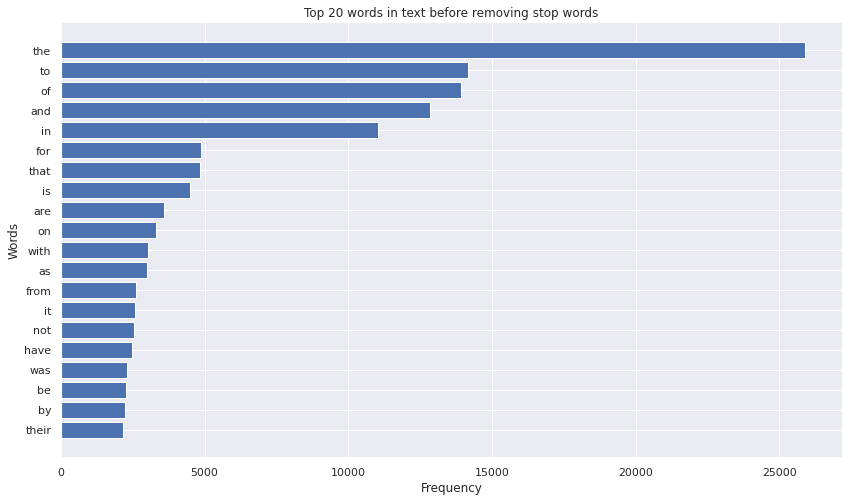

In [12]:
number = 20
common_words = get_top_n_words(df["text"], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df1["words"][::-1], df1["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

**4 N-Grams**

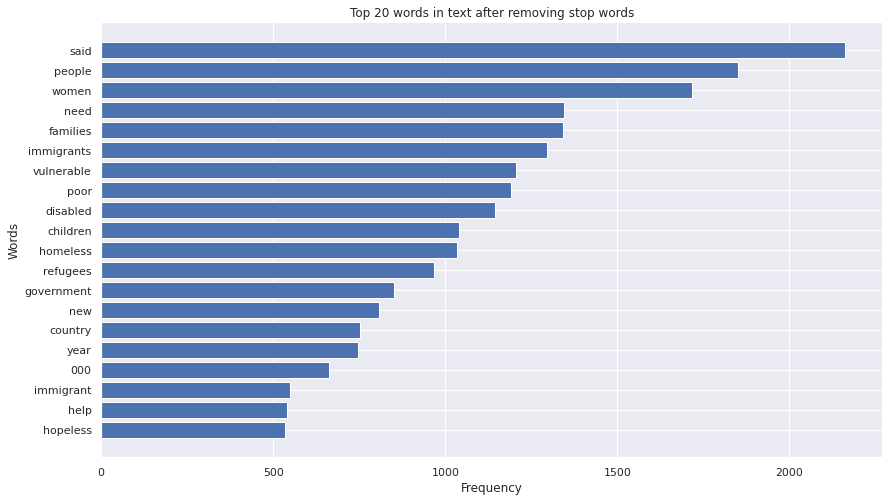

In [13]:
number=20
common_words = get_top_n_words_sw(df["text"], stop_word, language, number)
df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df2["words"][::-1], df2["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

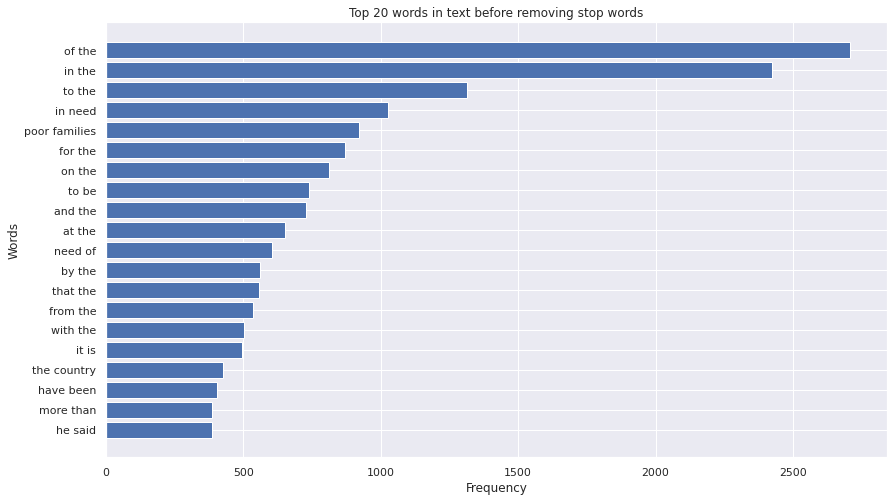

In [14]:
number = 20
common_words = get_top_n_bigram(df["text"], number)

df3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df3["words"][::-1], df3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

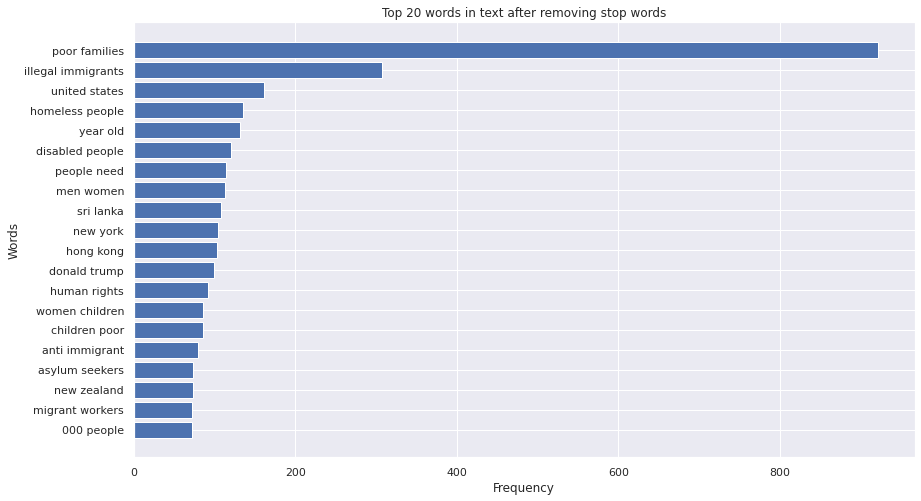

In [15]:
number = 20
common_words = get_top_n_bigram_sw(df["text"], stop_word, language, number)

df4 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df4["words"][::-1], df4["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

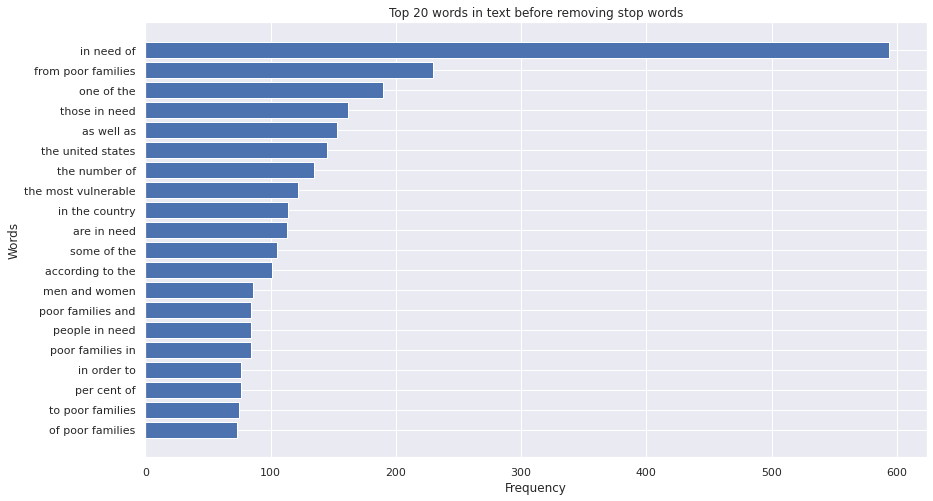

In [16]:
number = 20
common_words = get_top_n_trigram(df["text"], number)

df5 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df5["words"][::-1], df5["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

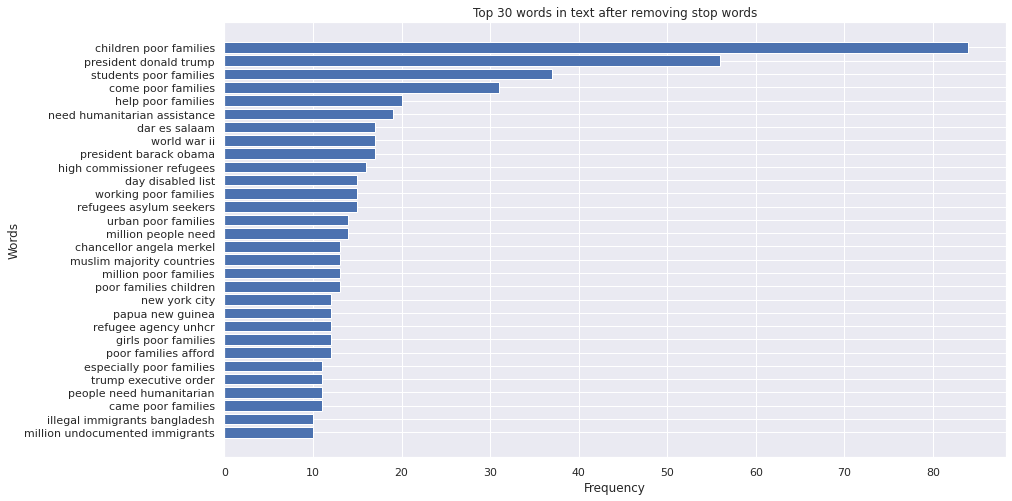

In [17]:
number = 30
common_words = get_top_n_trigram_sw(df["text"], stop_word, language, number)

df6 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df6["words"][::-1], df6["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)
#plt.savefig("trigram_sw.png")

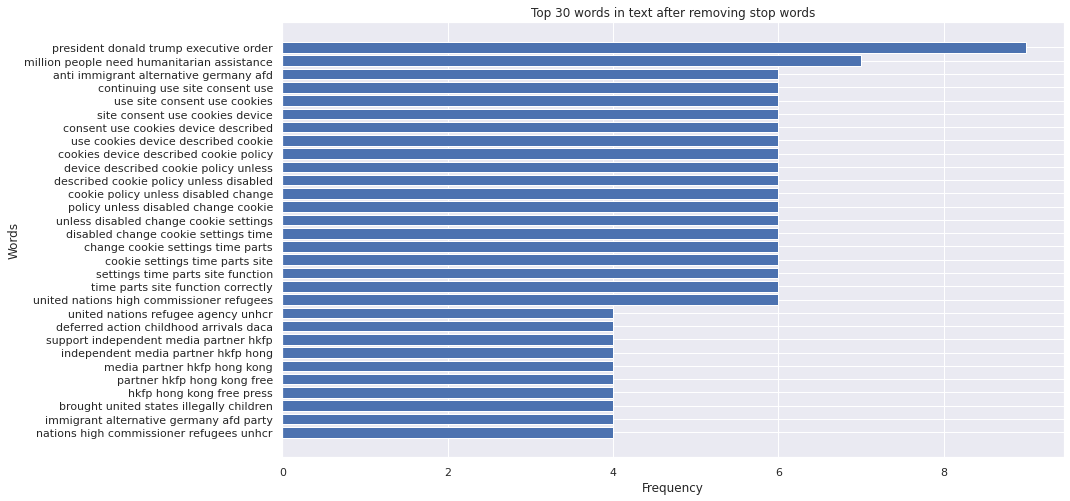

In [18]:
number = 30
common_words = get_top_n_5grams_sw(df["text"], stop_word, language, number)

df7 = pd.DataFrame(common_words, columns = ['words' , 'count'])

plt.figure(figsize=(14,8))
plt.barh(df7["words"][::-1], df7["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

**5 Processing**

In [19]:
df.loc[:,"text_sw"] = df.loc[:,"text"].progress_apply(lambda x : remove_stop_words(x, stop_word))

if df["text_sw"].isnull().sum()>0:
    print("Empty text")
    df["text_sw"][df["text_sw"].isnull()] = "empty_text"

100%|██████████| 10469/10469 [00:00<00:00, 44513.78it/s]


In [20]:
# train & test split

train_data,test_data = model_selection.train_test_split(df, test_size=0.2, random_state=39, stratify = df[["label"]])
train_data = train_data.drop(train_data[train_data["label"] == 0].sample(frac=0.1).index)
train_x = train_data["text"]
valid_x = test_data["text"]
y_train = train_data["label"]
y_valid = test_data["label"]


# label encode the target variable 
encoder = preprocessing.LabelEncoder()
#train_y_sw = encoder.fit_transform(y_train_sw)
#valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

# print(train_x.size)
# print(valid_x.size)
# print(y_train.size)
# print(y_valid.size)

In [21]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [22]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 0.5582	class: 0
Class weight: 4.7966	class: 1


In [23]:
# Keep the unique label corresponding to their encoding correspondance
labels = df["label"].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==2:
    labels = ["negative", "positive"]

In [24]:
pretrained = fasttext.FastText.load_model('../input/fasttext-common-crawl-bin-model/cc.en.300.bin')

In [25]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df["text"])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 30046/30046 [00:00<00:00, 78960.64it/s]

CPU times: user 1.16 s, sys: 49.8 ms, total: 1.21 s
Wall time: 1.21 s


Evaluation Metrics

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

**6 Model Building**

In [27]:
np.shape(train_seq_x)

(7617, 300)

In [28]:
#(1) deep model - variation1 

embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False, input_length=300)
model = keras.Sequential([
      embedded,
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),  
      #keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop', \
                              loss=tf.losses.BinaryCrossentropy(), \
                              metrics=['accuracy'])

# history_deep_model_var1 = model.fit(train_seq_x, train_y,
#                     epochs=20,
#                     validation_data=(valid_seq_x, valid_y), verbose=True)

model.summary()
model.fit(train_seq_x, train_y,
                    epochs=35,
                    validation_split=0.2, verbose=True)

model.save("deep_model_var1")

history_deep_model_var1 = model.history

2022-06-01 07:28:58.241983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 07:28:58.243919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 07:28:58.244657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-01 07:28:58.247285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          9014100   
_________________________________________________________________
dense (Dense)                (None, 300, 16)           4816      
_________________________________________________________________
dense_1 (Dense)              (None, 300, 16)           272       
_________________________________________________________________
dense_2 (Dense)              (None, 300, 1)            17        
Total params: 9,019,205
Trainable params: 5,105
Non-trainable params: 9,014,100
_________________________________________________________________
Epoch 1/35
191/191 [==============================] - 3s 5ms/step - loss: 0.4645 - accuracy: 0.8915 - val_loss: 0.3126 - val_accuracy: 0.9088
Epoch 2/35
191/191 [==============================] - 1s 4ms/step - loss: 0.3416 - accuracy: 0.892

2022-06-01 07:29:36.340840: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-06-01 07:29:37.569745: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36056400 exceeds 10% of free system memory.


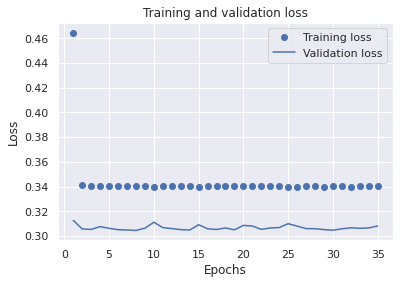

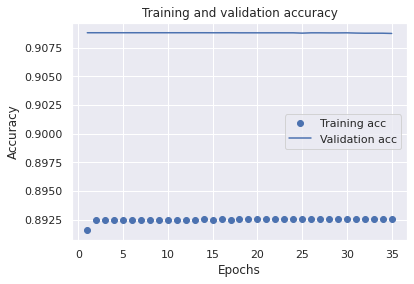

In [29]:
history_deep_model_var1_dict = history_deep_model_var1.history
loss_values = history_deep_model_var1_dict['loss']
val_loss_values = history_deep_model_var1_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('1-Loss.png')
plt.show()

acc_values = history_deep_model_var1_dict['accuracy']
val_acc_values = history_deep_model_var1_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('1-Accuracy.png')
plt.show()

In [30]:
#(2) convolutional model

embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False, input_length=300)
model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    

       
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop', \
                              loss=tf.losses.BinaryCrossentropy(from_logits=False), \
                              metrics=['accuracy'])

model.summary()

# history_conv_model = model.fit(train_seq_x, train_y,
#                     epochs=20,
#                     validation_data=(valid_seq_x, valid_y), verbose=True)

model.fit(train_seq_x, train_y,
                    epochs=7,
                    validation_split=0.2, verbose=True)

model.summary()
model.save("conv_model")

history_conv_model = model.history

2022-06-01 07:29:39.269359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36056400 exceeds 10% of free system memory.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          9014100   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           48032     
_________________________________________________________________
dropout (Dropout)            (None, 296, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 144, 32)           5152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 72, 32)           

2022-06-01 07:29:41.201871: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


191/191 [==============================] - 8s 8ms/step - loss: 0.3548 - accuracy: 0.8920 - val_loss: 0.3120 - val_accuracy: 0.9088
Epoch 2/7
191/191 [==============================] - 1s 6ms/step - loss: 0.3253 - accuracy: 0.8925 - val_loss: 0.2946 - val_accuracy: 0.9088
Epoch 3/7
191/191 [==============================] - 1s 6ms/step - loss: 0.2991 - accuracy: 0.8925 - val_loss: 0.2890 - val_accuracy: 0.9088
Epoch 4/7
191/191 [==============================] - 1s 7ms/step - loss: 0.2838 - accuracy: 0.8925 - val_loss: 0.3347 - val_accuracy: 0.9088
Epoch 5/7
191/191 [==============================] - 1s 7ms/step - loss: 0.2712 - accuracy: 0.8925 - val_loss: 0.2674 - val_accuracy: 0.9088
Epoch 6/7
191/191 [==============================] - 1s 7ms/step - loss: 0.2518 - accuracy: 0.8938 - val_loss: 0.2655 - val_accuracy: 0.9094
Epoch 7/7
191/191 [==============================] - 1s 8ms/step - loss: 0.2378 - accuracy: 0.9022 - val_loss: 0.3200 - val_accuracy: 0.8950
Model: "sequential_1"
_

2022-06-01 07:29:58.279473: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36056400 exceeds 10% of free system memory.


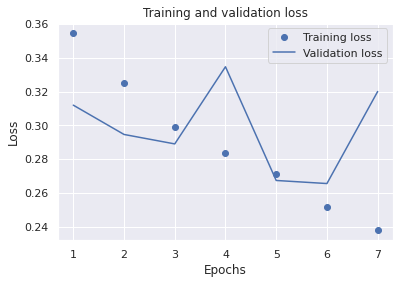

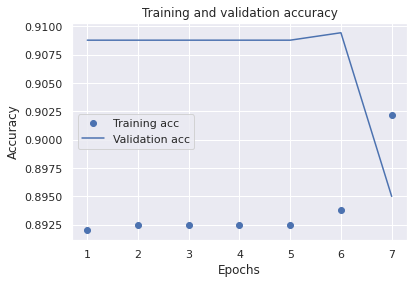

In [31]:
history_conv_model_dict = history_conv_model.history
loss_values = history_conv_model_dict['loss']
val_loss_values = history_conv_model_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('2-Loss.png')
plt.show()

acc_values = history_conv_model_dict['accuracy']
val_acc_values = history_conv_model_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('2-Accuracy.png')
plt.show()

In [32]:
#(3) bi gru

embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False, input_length=300)
model = keras.Sequential([
    embedded,

    keras.layers.Bidirectional(keras.layers.GRU(32,dropout=0.32,recurrent_dropout=0.32)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer='rmsprop', \
                              loss=tf.losses.BinaryCrossentropy(from_logits=False), \
                              metrics=['accuracy'])

# history_bi_gru_model = model.fit(train_seq_x, train_y,
#                     epochs=20,
#                     validation_data=(valid_seq_x, valid_y), verbose=True)

model.summary()
model.fit(train_seq_x, train_y,
                    epochs=18,
                    validation_split=0.2, verbose=True)

model.save("bi_gru_model")

history_bi_gru_model = model.history

2022-06-01 07:30:00.163629: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36056400 exceeds 10% of free system memory.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          9014100   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                64128     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

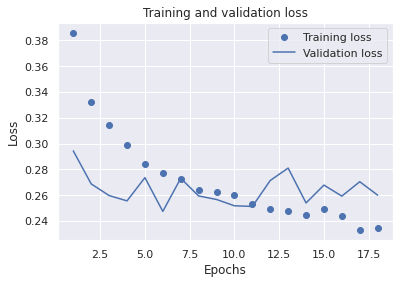

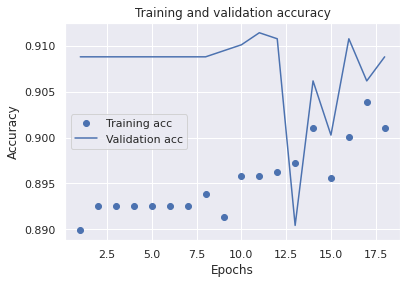

In [33]:
history_bi_gru_model_dict = history_bi_gru_model.history
loss_values = history_bi_gru_model_dict['loss']
val_loss_values = history_bi_gru_model_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('3-Loss.png')
plt.show()

acc_values = history_bi_gru_model_dict['accuracy']
val_acc_values = history_bi_gru_model_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('3-Accuracy.png')
plt.show()

In [34]:
#(4) rcnn -  var1

embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
model = keras.Sequential([
    embedded,

    keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True,dropout=0.25,recurrent_dropout=0.25)),
    
    keras.layers.Conv1D(16, 3, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.GlobalMaxPool1D(),
    
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])

model.summary()
model.compile(optimizer='rmsprop', \
                              loss=tf.losses.BinaryCrossentropy(from_logits=False), \
                              metrics=['accuracy'])

# history_rcnn_var1_model = model.fit(train_seq_x, train_y,
#                     epochs=20,
#                     validation_data=(valid_seq_x, valid_y), verbose=True)

model.fit(train_seq_x, train_y,
                    epochs=20,
                    validation_split=0.2, verbose=False)

model.save("rcnn_var1_model")

history_rcnn_var1_model = model.history

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         9014100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          85248     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          3088      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

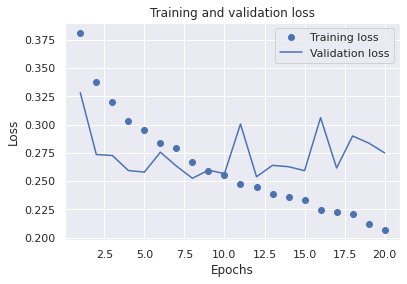

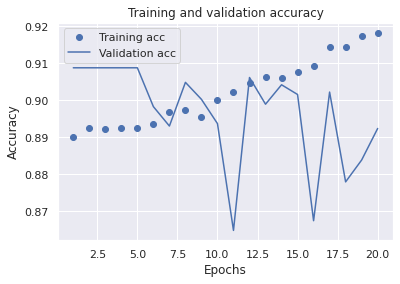

In [35]:
history_rcnn_var1_model_dict = history_rcnn_var1_model.history
loss_values = history_rcnn_var1_model_dict['loss']
val_loss_values = history_rcnn_var1_model_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('4-Loss.png')
plt.show()

acc_values = history_rcnn_var1_model_dict['accuracy']
val_acc_values = history_rcnn_var1_model_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('4-Accuracy.png')
plt.show()